# Explainer

### Import libraries

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from datasets import ASL_C_Dataset
from models import BaselineCNN
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from utils import parse_arguments, read_settings, save_checkpoint, load_checkpoint
import numpy as np
import shap

c:\Users\aless\miniconda3\envs\DLImageAnalysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# os.environ['https_proxy'] = "http://hpc-proxy00.city.ac.uk:3128"
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')
print('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'BaselineCNN_Backbone'

cpu


In [3]:
# Read settings from the YAML file
settings = read_settings(config_path='config.yaml')

# Access and use the settings as needed
data_settings = settings.get('data', {})
model_settings = settings.get('model', {})
train_settings = settings.get('train', {})

In [4]:
# Initialize
asl_dataset = ASL_C_Dataset(img_size=data_settings['img_size'])
data_len = len(asl_dataset)
train_len = int(data_len*data_settings['train_size'])
test_len = int((data_len - train_len)/2)
val_len = data_len - train_len - test_len
asl_dataset_train, asl_dataset_test, asl_dataset_valid = random_split(asl_dataset, [train_len, test_len, val_len])

# test data loader
asl_testloader = DataLoader(asl_dataset_test, batch_size=1, shuffle=True)

# Baseline model for evaluating
baselinemodel = BaselineCNN(img_dim=data_settings['img_size'], num_classes=data_settings['num_output'], num_kernels=model_settings['num_kernels'],
                            num_filters1=model_settings['num_filters1'], num_filters2=model_settings['num_filters2'], num_hidden=model_settings['num_hidden'],
                            num_hidden2=model_settings['num_hidden2'], pooling_dim=model_settings['pooling_dim'], stride=model_settings['stride'], padding=model_settings['padding'],
                            stridepool=model_settings['stridepool'], paddingpool=model_settings['paddingpool'])
ckptfile = "BaselineCNN_5_ckpt.pth"
optimizer = torch.optim.Adam(list(baselinemodel.parameters()), lr = train_settings['learning_rate'])

load_checkpoint(baselinemodel, optimizer, ckptfile)

baselinemodel = baselinemodel.to(device)

In [5]:
# Background using training samples
asl_trainloader = DataLoader(asl_dataset_train, batch_size=5, shuffle=True)
background_images = []
for i, (images, _) in enumerate(asl_trainloader):
    background_images.append(images)
    if i == 2:  # Collect 10 batches, adjust based on your dataset size and memory constraints
        break

background_np = torch.cat(background_images, dim=0) # Concatenate all collected images
print(background_np.shape)

torch.Size([15, 3, 320, 320])


In [6]:
# Initialize the SHAP DeepExplainer
explainer = shap.DeepExplainer(baselinemodel, background_np)

In [7]:
# Explaining
images, _ = next(iter(asl_testloader))
images_np = images.numpy()

# Explain predictions for the new images
shap_values = explainer.shap_values(images)

c:\Users\aless\miniconda3\envs\DLImageAnalysis\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [8]:
mean=[0.485, 0.457, 0.407],
std=[0.224, 0.224, 0.225]
def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image).float()

(320, 320, 3)
(320, 29, 320)
(1, 3, 320, 320, 29)
(3, 320, 320)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


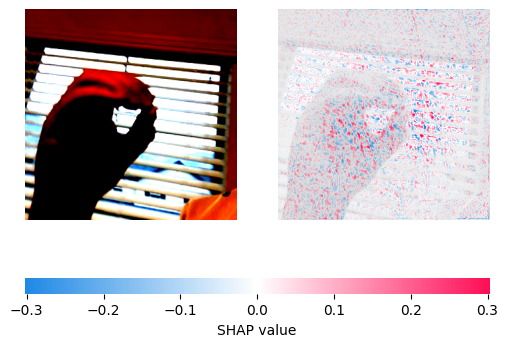

In [9]:
# Select the first image in the batch and transpose it to (height, width, channels)
image_to_plot = images_np[0].transpose(1, 2, 0)
print(image_to_plot.shape)

# Since shap_values will also be in the form (batch_size, channels, height, width),
# you should select and transpose in similar fashion:
shap_values_to_plot = [sv[0].transpose(1, 2, 0) for sv in shap_values]
print(shap_values_to_plot[0].shape)
print(shap_values.shape)
print(shap_values[0,:,:,:,-2].shape)
#shap_values_to_plot = shap_values
# Plot the SHAP values
shap.image_plot(shap_values[0,:,:,:,-1].transpose(1,2,0), image_to_plot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


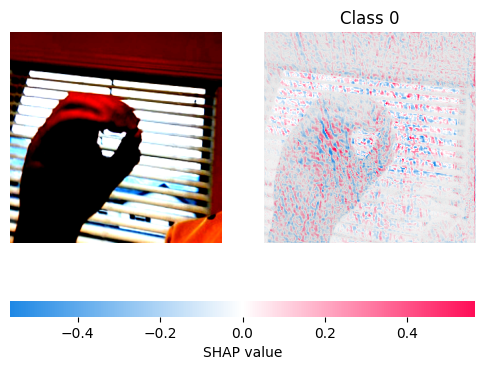

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


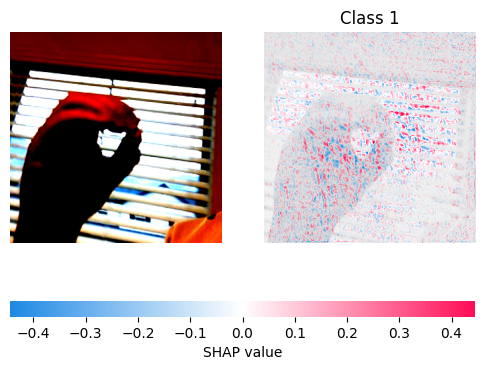

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


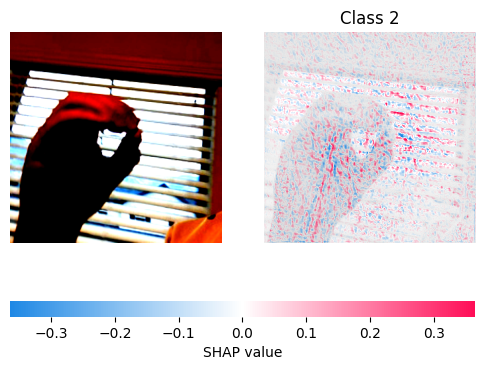

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


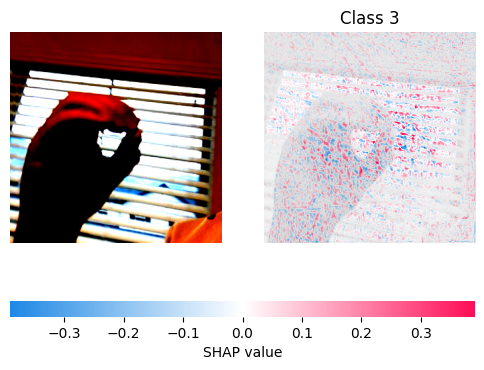

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


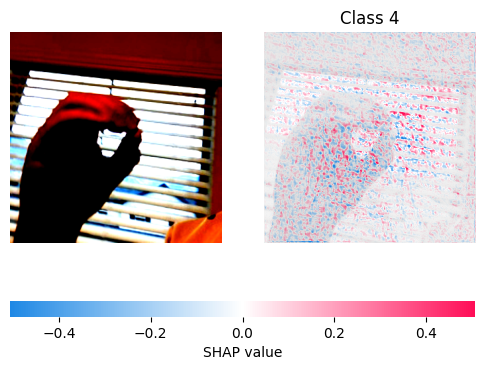

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


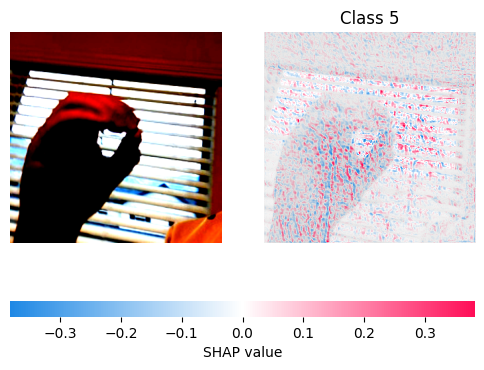

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


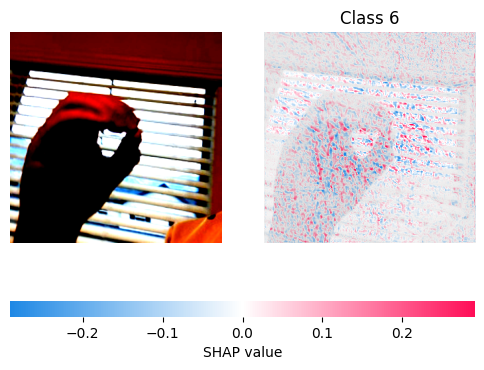

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


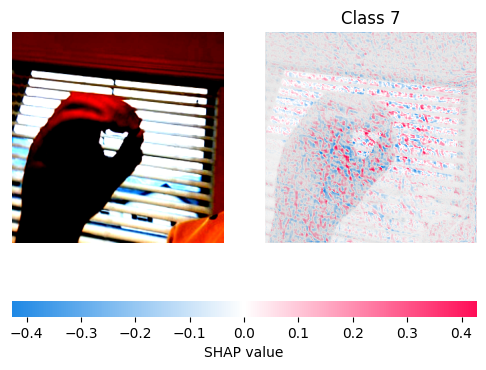

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


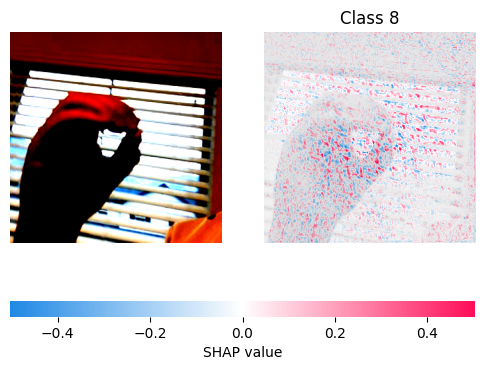

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


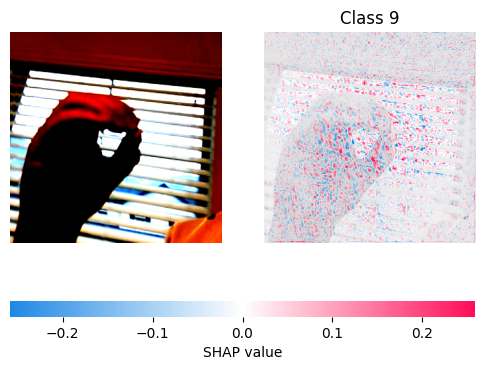

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


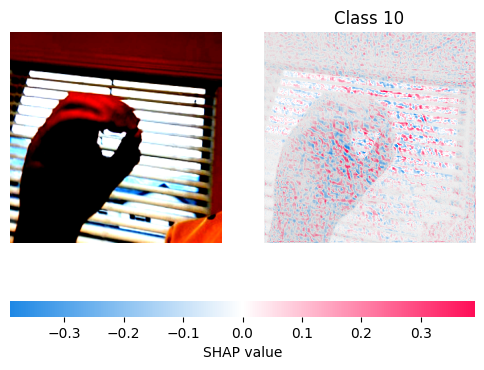

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


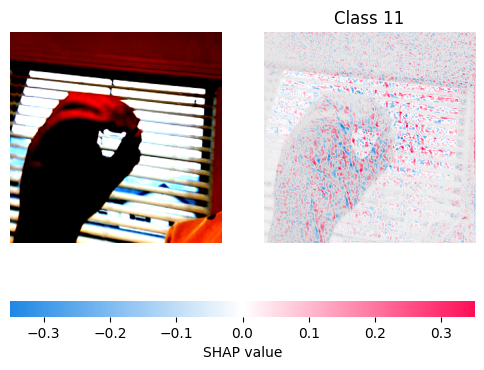

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


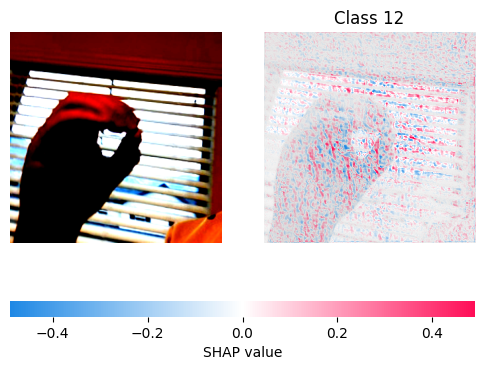

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


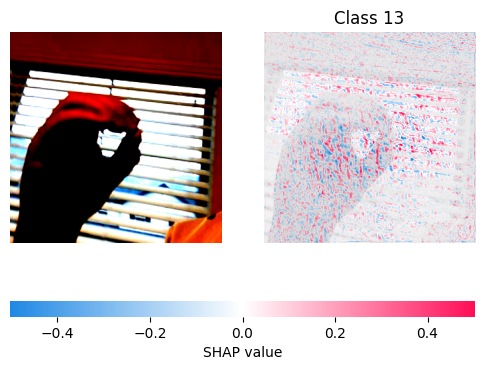

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


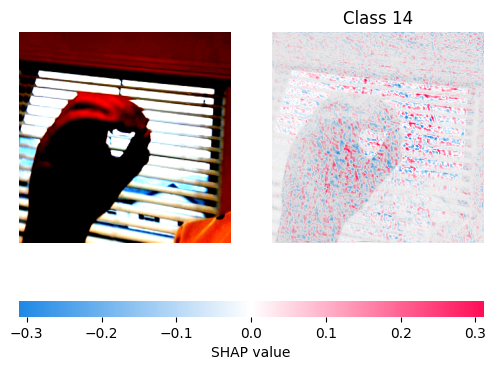

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


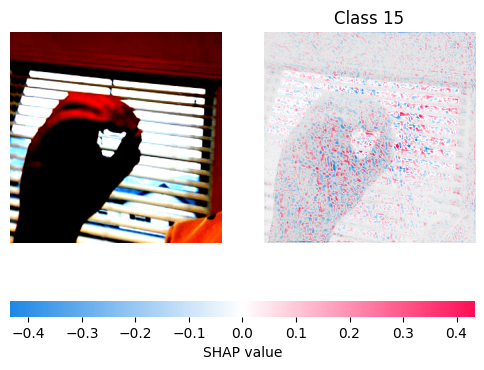

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


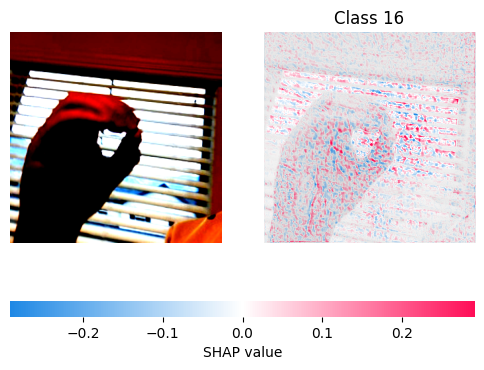

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


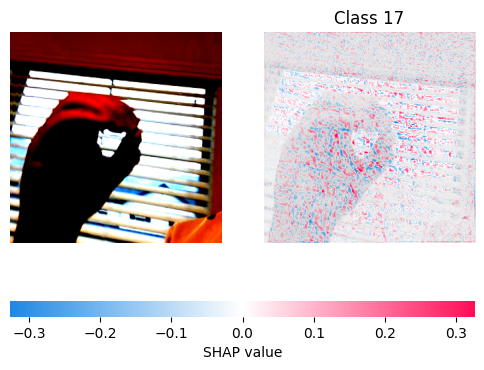

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


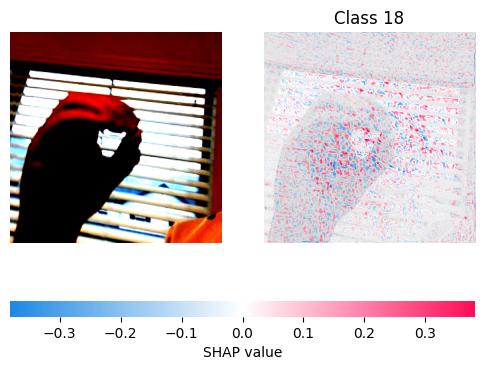

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


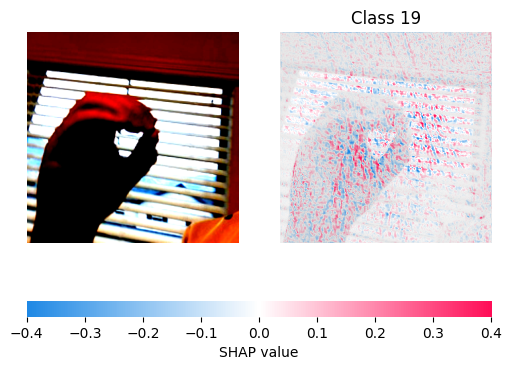

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


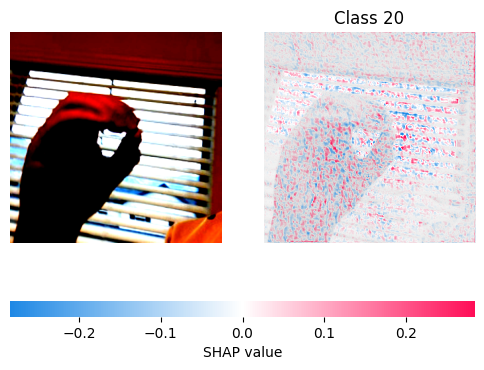

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


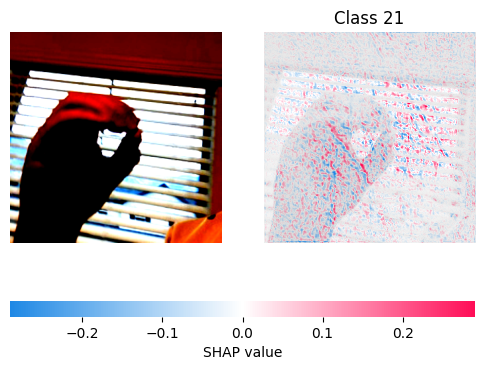

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


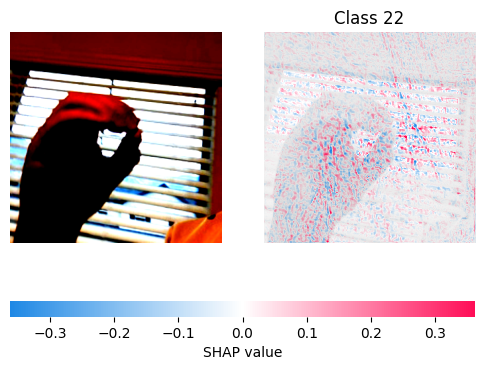

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


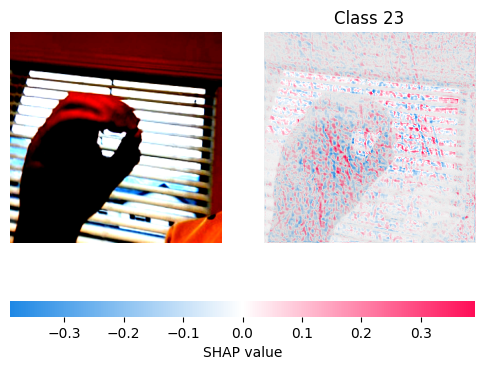

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


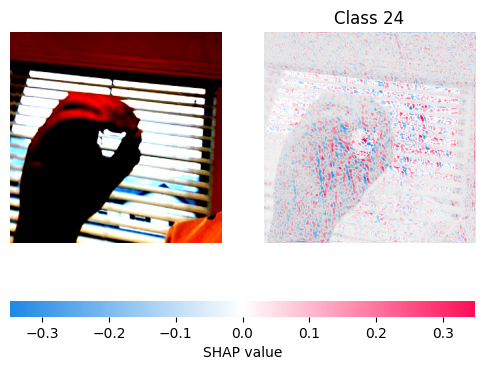

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


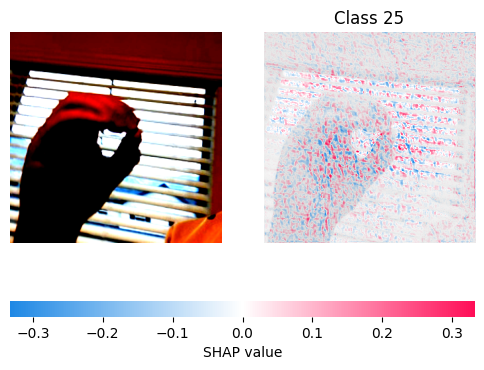

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


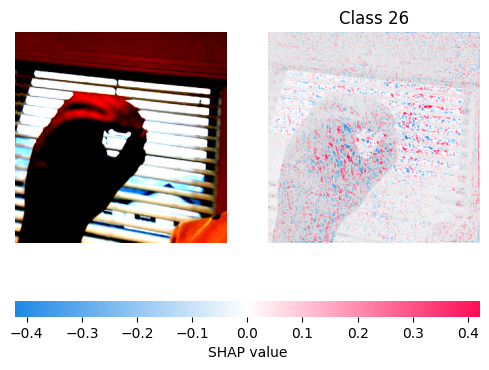

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


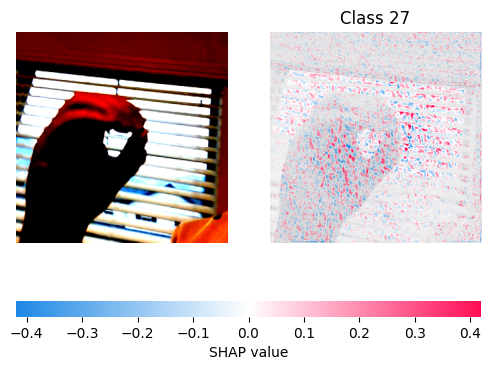

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


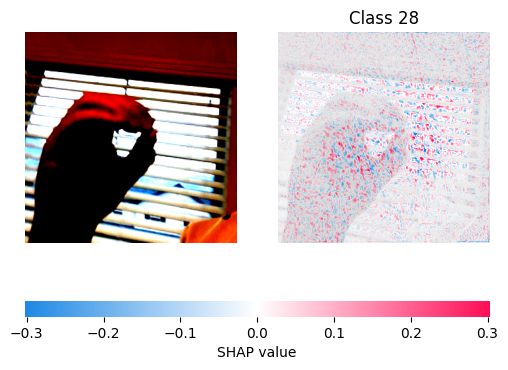

In [10]:
import matplotlib.pyplot as plt
for i in range(shap_values.shape[-1]):
    shap_values_to_plot = shap_values[0,:,:,:,i].transpose(1,2,0)
    
    shap.image_plot(shap_values_to_plot, image_to_plot, show=False)
    plt.title(f"Class {i}")
    plt.show()